<a href="https://colab.research.google.com/github/zahra370/D_PROJ2/blob/main/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.5 MB/s eta 0:00:00


In [ ]:
pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import os
import imageio
import random
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
import segmentation_models as sm

Segmentation Models: using `keras` framework.


1525


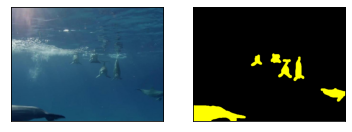

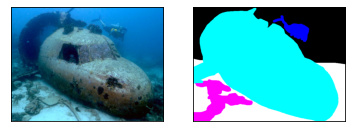

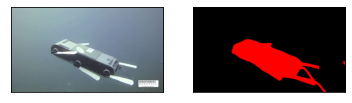

In [ ]:
dirname = r"/content/drive/MyDrive/sem_seg/train"
filenames = os.listdir(os.path.join(dirname,'images'))
filenames = [x for x in filenames if x.endswith('jpg')]
print(len(filenames))
nums = random.sample(range(len(filenames)),3)
for num in nums:
    filename = filenames[num]
    img = imageio.imread(os.path.join(dirname,'images', filename))
    lab = imageio.imread(os.path.join(dirname,'masks', filename[:-3] + 'bmp'))
    plt.figure()
    ax = plt.subplot(121)
    plt.imshow(img)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax = plt.subplot(122)
    plt.imshow(lab)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [ ]:
dict = {'classes': ['Background', 'Human divers', 'Aquatic plants and sea-grass', 'Wrecks and ruins', 'Robots', 'Reefs and invertebrates', 'Fish and vertebrates', 'Sea-floor and rocks'], 
        'colors': [(0,0,0), (0,0,255), (0,255,0), (0,255,255), (255,0,0), (255,0,255), (255,255,0), (255,255,255)]}

img_dim = (256,256,3)
perc_train = 0.8
batch_size=32
n_classes=8

In [ ]:
paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/sem_seg/train'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

im_files = [x for x in paths if x.endswith('jpg')]
lab_files = [x for x in paths if x.endswith('bmp')]
im_files.sort()
lab_files.sort()

In [ ]:
len(im_files)
len(lab_files)

1525

In [ ]:
def labelize(label):
    m,n,b = label.shape
    ref = np.zeros((m,n))
    for i,col in enumerate(dict['colors']):
        ref[np.all(label == col,axis=-1)] = i
    return ref

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, list_labels, batch_size=32, img_dim = (256,256), n_channels = 3, n_classes=10, shuffle=True):
        'Initialization'
        self.dim = img_dim
        self.batch_size = batch_size
        self.labels = list_labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        list_lab_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp, list_lab_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, list_labels):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = img_to_array(load_img(ID,target_size = ( *self.dim, self.n_channels), interpolation = 'bicubic'))/255

            # Store class
            yy = img_to_array(load_img(list_labels[i], target_size = ( *self.dim, self.n_channels), interpolation= 'nearest'))
            y[i,] = labelize(yy)
        return X, to_categorical(y, num_classes=self.n_classes)

In [ ]:
#  ensemble model 

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
import focal_loss
import matplotlib.pyplot as plt
import os
import imageio
import random
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
import segmentation_models as sm


# model1 = load_model('saved_models/unet.hdf5')
model1 = load_model("/content/drive/MyDrive/unet.hdf5", compile=False)

model1 = Model(inputs=model1.inputs,
                outputs=model1.outputs,
                name='name_of_model1')

model2 = load_model("/content/drive/MyDrive/deeplabv3+ (1).hdf5", compile=False)

model2 = Model(inputs=model2.inputs,
                outputs=model2.outputs,
                name='name_of_model2')


models = [model1, model2]

model_input = Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
# ensemble_model.compile(optimizer='adam', loss=loss, metrics=metrics)

In [ ]:

metrics=['accuracy', jaccard_coef]
loss = sm.losses.DiceLoss() 
ensemble_model.compile(optimizer='adam', loss=loss, metrics=metrics)

In [ ]:
paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/sem_seg/test'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

t_in_files = [x for x in paths if x.endswith('jpg')]
t_lab_files = [x for x in paths if x.endswith('bmp')]
t_in_files.sort()
t_lab_files.sort()

test_set = []
test_lab = []
for i in range(len(t_in_files)):
    test_set.append(img_to_array(load_img(t_in_files[i],target_size = img_dim, interpolation = 'bicubic'))/255)
    yy = img_to_array(load_img(t_lab_files[i], target_size = img_dim, interpolation= 'nearest'))
    test_lab.append(to_categorical(labelize(yy),num_classes=8))
test_set = np.asarray(test_set)
test_lab = np.asarray(test_lab)

y_pred=model1.predict(test_set)
Jacc = jaccard_coef(test_lab,y_pred)
print('IoU = {}'.format(Jacc))
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_lab, axis=3)


4/4 [==============================] - 12s 3s/step
IoU = 0.24311286211013794


1/1 [==============================] - 0s 196ms/step


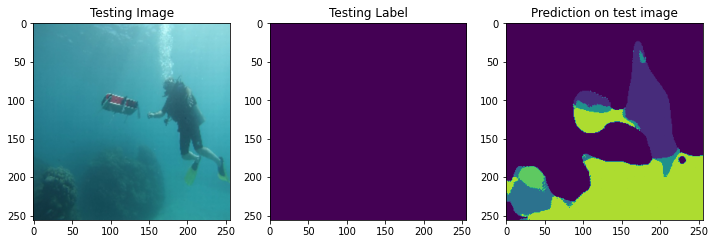

1/1 [==============================] - 0s 127ms/step


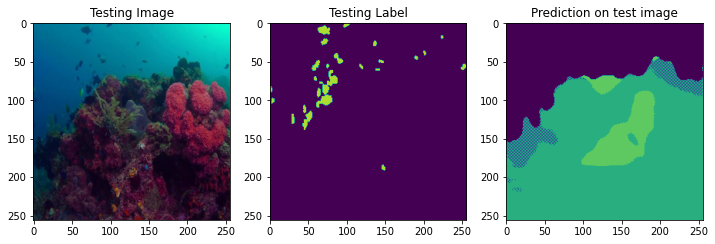

1/1 [==============================] - 0s 121ms/step


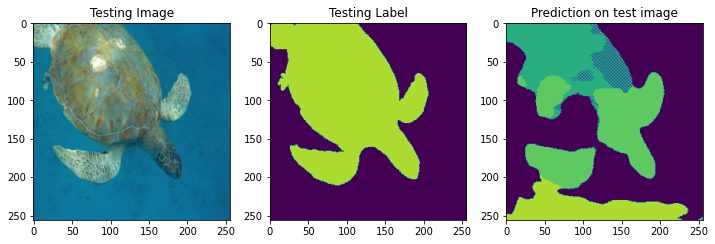

1/1 [==============================] - 0s 118ms/step


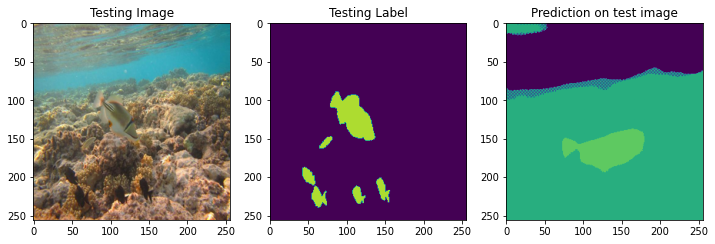

1/1 [==============================] - 0s 115ms/step


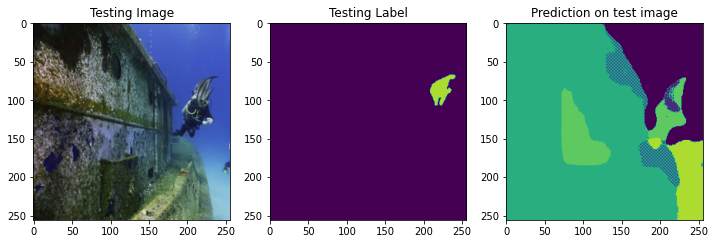

In [ ]:
num_samples = 5
test_img_numbers = random.sample(range(test_set.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = test_set[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model1.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()